<a href="https://colab.research.google.com/github/ethanfwilliams/OOI_RCA_DAS_notebook/blob/main/OOI_RCA_OptaSense_DAS_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OOI RCA DAS
## Introduction to OptaSense data
Author: [Ethan Williams](mailto:efwillia@caltech.edu)




This notebook serves as anintroduction to the OptaSense QuantX data acquired on the OOI RCA cables in Nov 2021. I first go through the HDF5 file format and demonstrate how to read the data and access metadata. Then, I offer some basic examples of data visualization and processing. Finally, I demonstrate an interpolation procedure for channel geolocalization given limited information about the cable path. 

In [2]:
# Initialize libraries for visualization with IPython
%pylab inline

# Install libraries missing from Google's default environment
!pip install pyproj

# Import some other libraries we will use explicitly
import h5py
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Proj

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Download an example file

I am temporarily hosting a single 1-minute file on my personal website. In the future you may have to obtain the data yourself from the OOI server. 

In [3]:
!wget https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5

--2022-02-27 03:52:19--  https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5
Resolving www.its.caltech.edu (www.its.caltech.edu)... 131.215.239.20
Connecting to www.its.caltech.edu (www.its.caltech.edu)|131.215.239.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815111372 (777M)
Saving to: ‘North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5’

North-C1-LR-P1kHz-G 100%[===================>] 777.35M  42.0MB/s    in 19s     

2022-02-27 03:52:38 (40.8 MB/s) - ‘North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5’ saved [815111372/815111372]



### Reading HDF5 files and accessing metadata

HDF5 stands for "Hierarchical Data Format, version 5". HDF5 is a flexible alternative to conventional seismic data formats that permits us to store large volumes of binary data along with appropriate metadata. One principal advantage of the HDF5 format is that it permits efficient slicing&mdash;for instance, you can read the data for a single channel without having to load the entire file into memory. Another advantage is that HDF5 permits concurrent read/write operations, which is convenient for parallel computing applications. 

HDF5 files contain two types of object: groups and datasets. Groups put the "hierarchical" in HDF5, and act like folders, containing other groups or datasets. Datasets are exactly what they sound like&mdash;the actual data. All objects in an HDF5 file have attributes, which are the metadata associated with that object. We can access an object or its attributes with keys, in a similar manner to Python dictionaries. 

First, let's open the file and print its contents. 

In [4]:
# The path to your file
fpath = './North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'

# Open the file for reading
fp = h5py.File(fpath,'r')

# Print the keys for the top-level object in the file
print(fp.keys())

<KeysViewHDF5 ['Acquisition']>


As you can see, the top-level object in this file is a group called "Acquisition". Before going down a step, we can print the metadata attributes associated with the "Acquisition" group. Here we can obtain some basic information about the acquisition including the gauge length, pulse rate, and spatial sampling interval. 

In [6]:
# Print the attributes for "Acquisition"
print(fp['Acquisition'].attrs.keys())

# Print the values associated with some important attributes
print('\nThe gauge length is ',fp['Acquisition'].attrs['GaugeLength'],'m.')
print('The pulse rate is ',fp['Acquisition'].attrs['PulseRate'],'Hz.')
print('The spatial sampling interval is ',fp['Acquisition'].attrs['SpatialSamplingInterval'],'m.')

<KeysViewHDF5 ['AcquisitionId', 'GaugeLength', 'GaugeLengthUnit', 'MaximumFrequency', 'MinimumFrequency', 'NumberOfLoci', 'PulseRate', 'PulseWidth', 'PulseWidthUnit', 'SpatialSamplingInterval', 'SpatialSamplingIntervalUnit', 'StartLocusIndex', 'TriggeredMeasurement', 'VendorCode', 'schemaVersion', 'uuid']>

The gauge length is  51.04762 m.
The pulse rate is  1000.0 Hz.
The spatial sampling interval is  2.0419047 m.


Within the "Acquisition" group, there are two groups: "Custom" and "Raw\[0\]". 

The first group "Custom" has attributes with more detailed information about the status and settings of the interrogator at the time of acquisition, such as whether the GPS clock was synced, whether decimation was applied to the streaming data, and the (hard coded) value of fiber refractive index used to convert time into distance. There are no further subgroups within "Custom". You can list the available attributes here with `fp['Acquisition']['Custom'].attrs.keys()`. 

The second group "Raw\[0\]" is a container for three more groups: "Custom" (not the same as above), "RawDataTime", and "RawData". The first of these, "Custom" is generally empty. The second, "RawDataTime", is a dataset containing the UTC timestamp for each sample in the file in units of microseconds. The third, "RawData", is the actual data. 

First, let's look at the "RawDataTime" dataset. We can treat it similarly to a NumPy array and index directly from the dataset object. 

In [7]:
# Create a new variable for the "RawDataTime" h5py dataset so we don't have to type so much
rawDataTime = fp['Acquisition']['Raw[0]']['RawDataTime']

# Get the first entry in "RawDataTime"
print('The first value in \"RawDataTime\" is',rawDataTime[0],\
      'which is the timestamp of the first sample in microseconds.')

# Convert this UTC timestamp to something readable with Python's datetime library
print('This equates to the date and time',datetime.utcfromtimestamp(rawDataTime[0]*1e-6))

# We can load the full contents of "RawDataTime" into a NumPy array
rawDataTimeArr = rawDataTime[:]

# Print the length of the array
print('\nThere are',len(rawDataTimeArr),'values in \"RawDataTime\"')

# Print the beginning and ending time of the dataset
print('The first sample is at',datetime.utcfromtimestamp(rawDataTimeArr[0]*1e-6),\
      'and the last sample is at',datetime.utcfromtimestamp(rawDataTimeArr[-1]*1e-6))

The first value in "RawDataTime" is 1635992582025000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-04 02:23:02.025000

There are 12000 values in "RawDataTime"
The first sample is at 2021-11-04 02:23:02.025000 and the last sample is at 2021-11-04 02:24:02.020000


Given the sampling rate here is 200 Hz, we see, as expected, that there are 200 x 60 = 12000 samples spanning one minute, and that the UTC timestamps for each sample also span exactly one minute down to millisecond precision. 

Now that we understand how groups, datasets, and attributes work in HDF5, let's take a look at the actual DAS data. This is stored in the dataset object at `fp['Acquisition']['Raw[0]']['RawData']`. This is a 2D dataset (channel/distance vs. time), as evidenced by the string stored in the attribute `rawData.attrs['Dimensions']`. This order is determined by a recording software user switch allowing to store the data in trace-order or channel-order. Generally the first axis is distance, and the second axis is time, for fast time-domin processing, and is normally constant throughout the reocrding. It is good to check this attribute value when reading a file. 

We can read a single channel using the syntax `rawData[channel#,:]`, a block of channels as `rawData[firstChannel:lastChannel,:]`, a time slice as `rawData[:,firstSample:lastSample]`, etc. 

Sampling rate derived from timestamps: 200.0 Hz
Sampling rate derived from metadata: 200.0 Hz


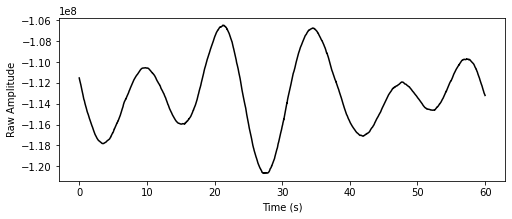

In [18]:
# Create a new variable for the "RawData" h5py dataset
rawData = fp['Acquisition']['Raw[0]']['RawData']

# Get the data for a single channel
trace = rawData[5000,:]

# In order to plot this trace, we need a time axis
# We can get the sample interval either from the time stamps or from the metadata
dt = (rawDataTime[1]-rawDataTime[0]) * 1e-6
fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
print('Sampling rate derived from timestamps:',1./dt,'Hz')
print('Sampling rate derived from metadata:',fs,'Hz')

# Now, plot it
time = np.arange(len(trace)) * dt
plt.figure(figsize=(8,3))
plt.plot(time,trace,'k')
plt.xlabel('Time (s)')
plt.ylabel('Raw Amplitude');

There are two important points to notice here: 
* The amplitude of the raw data is not in units of strain. Rather, it is still in units of unwrapped optical phase (radians multiplied by a constant). 
* The average value is large because the phase is tracked from the start of the DAS system and drifts over long time periods due to temperature effects for each channel indepently. We will have to remove the mean to compare adjacent channels later.

The units are given in the attribute `fp['Acquisition']['Raw[0]'].attrs['RawDataUnit']`. In order to convert these to strain, we first remove the constant factor to return units of radians, and then we apply the following formula:

\begin{equation}
    \varepsilon = \frac{1550.12 \times 10^{-9}}{0.78 \times 4 \pi \times n \times L} \Delta\Phi
\end{equation}

Here 1550.12x1e-9 is the wavelength in meters and $L$ is the gauge length in meters, so the result is in units of strain. Notably we do not know the exact index of refraction ($n$) of any given fiber---a typical value is 1.46, but you can also use the reference value stored in the metdata at `fp['Acquisition']['Custom'].attrs['Fibre Refractive Index']`. To understand the other constants, I refer you to [Lindsey et al. (2020)](https://doi.org/10.1029/2019JB018145) or [Lindsey & Martin (2021)](https://doi.org/10.1146/annurev-earth-072420-065213). Because this conversion factor is simply a constant, it is generally unnecessary to convert the data units before processing (unless computing a value like PSD which you wish to compare with other data, of course). 

The raw data unit is b'rad * 2PI/2^16'


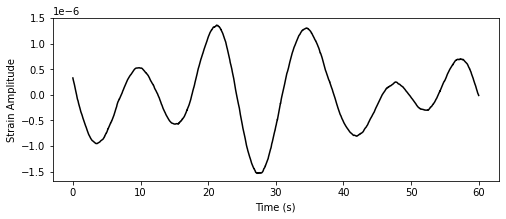

In [19]:
# Print the units
print('The raw data unit is',fp['Acquisition']['Raw[0]'].attrs['RawDataUnit'])

# Remove the mean from the trace
trace = trace.astype(float)
trace -= np.mean(trace)

# Convert to units of radians
trace *= (2*np.pi)/2**16

# Convert to units of strain
n = fp['Acquisition']['Custom'].attrs['Fibre Refractive Index']
L = fp['Acquisition'].attrs['GaugeLength']
trace *= (1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L)

# Now plot again in strain units
plt.figure(figsize=(8,3))
plt.plot(time,trace,'k')
plt.xlabel('Time (s)')
plt.ylabel('Strain Amplitude');

### Exploring the OOI RCA DAS data

Now that we know how to read the OptaSense DAS data and convert it into physical units of strain, let's visualize different parts of the dataset and see what's there. 

First, we can load a subset of channels and plot them, along with their power spectra. 

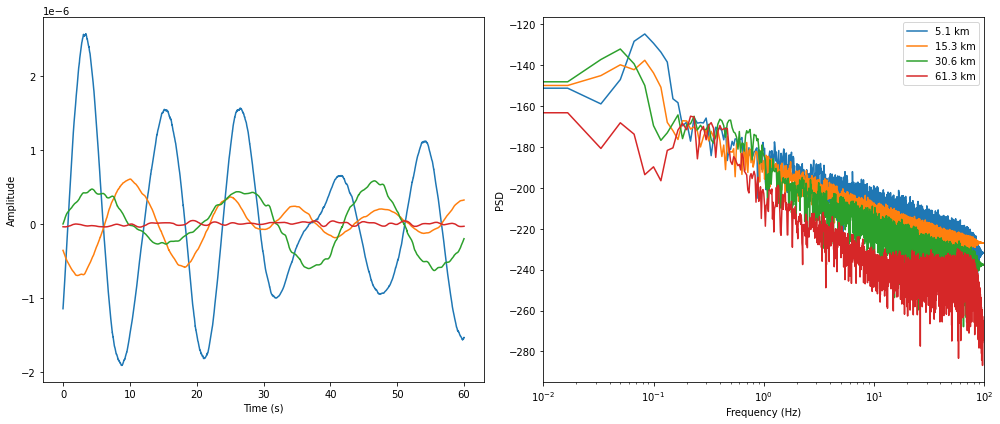

In [20]:
# Assemble the metadata we will need
fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate'] # sampling rate in Hz
dx = fp['Acquisition'].attrs['SpatialSamplingInterval'] # channel spacing in m
nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci'] # number of channels
ns = fp['Acquisition']['Raw[0]']['RawDataTime'].attrs['Count'] # number of samples
L = fp['Acquisition'].attrs['GaugeLength'] # gauge length in m
n = fp['Acquisition']['Custom'].attrs['Fibre Refractive Index'] # refractive index
scale_factor = (2*np.pi)/2**16 * (1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L)

# Create some useful arrays
t = np.arange(ns)/fs # time in s
x = np.arange(nx)*dx # distance in m
frq = np.fft.rfftfreq(ns,d=1./fs) # frequency in Hz

# Calculate and plot the spectrum for a few channels
chans = [2500,7500,15000,30000]
fig,ax = plt.subplots(1,2,figsize=(14,6))
for chan in chans:
    tr = rawData[chan,:].astype(float) # get the data at each channel
    tr -= np.mean(tr) # remove the mean
    tr *= scale_factor # convert to strain
    ftr = 20 * np.log10( (2/ns) * abs(np.fft.rfft(tr * np.hamming(ns))) ) # calculate the PSD
    ax[0].plot(t,tr)
    ax[1].plot(frq,ftr,label='%.1f km' % (chan*dx*1e-3))
ax[1].set_xscale('log')
ax[1].set_xlim([1e-2,1e2])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

Even with just this one minute of data, we can see a bimodal spectrum, with the lower-frequency peak consisting primarily of ocean waves and the higher-frequency peak consisting of seismic waves. In shallow water, the data is dominated by ocean surface gravity waves with a dominant period around 14 seconds. This ocean wave energy is strongest near the coast and decays with distance because of the increasing water depth. The seismic energy appears similar throughout. 

In order to characterize these two distinct phases, we can load a block of adjacent channels and perform some basic array analysis. 

In [ ]:
# Load a new block of data in intermediate water depth
xmin = 10000
xmax = 15000
xint = 5
tmin = 0
tmax = len(t)
tint = 10
# for speed, I'm just taking every 5th channel and 10th sample but this is bad practice and will cause aliasing
tr = rawData[xmin:xmax:xint,tmin:tmax:tint].astype(float)
# the dimensions of our data block
nnx = tr.shape[0]
nns = tr.shape[1]

# Remove the mean from each channel
mn = np.tile(np.mean(tr,axis=1),(nns,1)).T
tr = tr - mn

# Define new time and distance axes
time = np.arange(nns)*tint/fs
dist = (np.arange(nnx)*xint + xmin)*dx

# Define frequency and wavenumber axes
freq = np.fft.fftshift(np.fft.fftfreq(nns,d=tint/fs))
knum = np.fft.fftshift(np.fft.fftfreq(nnx,d=xint*dx))

# Calculate the frequency-wavenumber spectrum
ft2 = np.fft.fftshift(np.fft.fft2(tr))
ft2 = np.log10(abs(ft2)) # this is not normalized

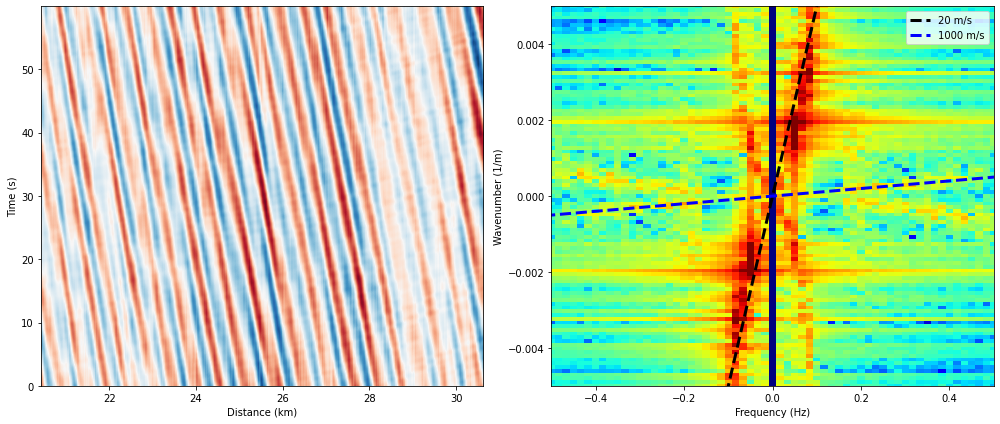

In [ ]:
# Plot the data in the time domain
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].imshow(tr.T,extent=[min(dist)*1e-3,max(dist)*1e-3,min(time),max(time)],aspect='auto',\
             origin='lower',cmap='RdBu')
ax[0].set_xlabel('Distance (km)')
ax[0].set_ylabel('Time (s)')

# Plot the frequency-wavenumber spectrum
ax[1].imshow(ft2,extent=[min(freq),max(freq),min(knum),max(knum)],aspect='auto',origin='lower',\
             cmap='jet',vmin=7,vmax=11)
ax[1].plot(freq,freq/20,'k--',linewidth=3,label='20 m/s')
ax[1].plot(freq,freq/1000,'b--',linewidth=3,label='1000 m/s')
ax[1].set_xlim([-0.5,0.5])
ax[1].set_ylim([-0.005,0.005])
ax[1].legend()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Wavenumber (1/m)')
plt.tight_layout()

In the time domain we can easily see the ocean wave groups moving steadily towards shore at about 20 m/s. With a 2D FFT to the frequency-wavenumber domain, we can see that some ocean waves are actually propagating in the opposite direction away from shore. We can also observe seismic energy across a broad band (~2-8 seconds period) propagating in both directions along the array. 

In addition to these ambient environmental signals, the OOI RCA DAS dataset also contains acoustic signals from fin whale vocalization. These vocalizations occur every 20-30 seconds and appear on both cables throughout almost the full duration of the recording. There may be further discrete signals such as ship noise, earthquakes, and other marine mammal vocalizations, but these have not been catalogued in detail yet. 

The following is a fin whale record from our arbitrary example file. The frequency band of interest is about 15-25 Hz, and the whale is located near the middle of the cable. In order to help visualize this, we can simulate a "waterfall" plot by narrow-band filtering the data and plotting the envelope. 

In [ ]:
# Select a block of data from the middle of the cable
xmin = 10000
xmax = 15000
xint = 5
tmin = int(30*fs)
tmax = int(36*fs)
tint = 1
tr = rawData[xmin:xmax:xint,tmin:tmax:tint]
nnx = tr.shape[0]
nns = tr.shape[1]

# Remove the mean from each channel
mn = np.tile(np.mean(tr,axis=1),(nns,1)).T
tr = tr - mn

# Bandpass filter 15-25 Hz
b, a = sp.butter(8,[15/(fs/2/tint),25/(fs/2/tint)],'bp')
tr = sp.filtfilt(b,a,tr,axis=1)

# Calculate envelope
en = abs(sp.hilbert(tr,axis=1))

# Define new time and distance axes
time = (np.arange(nns)*tint + tmin)/fs
dist = (np.arange(nnx)*xint + xmin)*dx

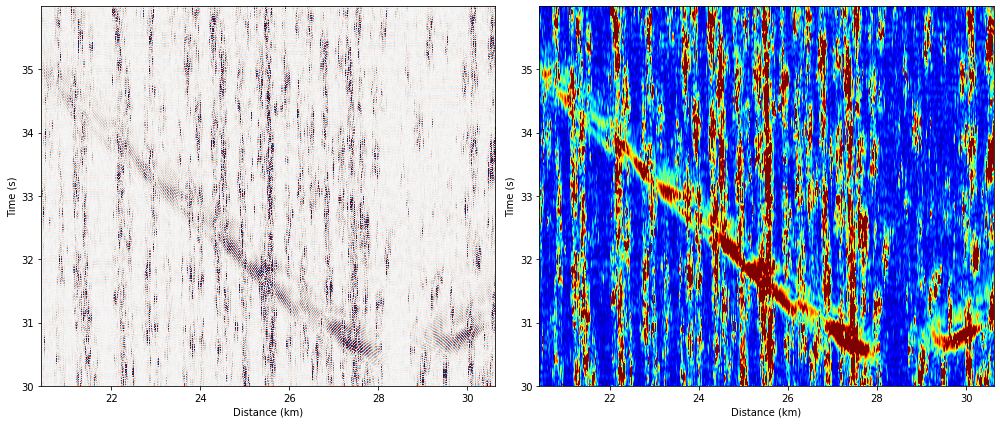

In [ ]:
# Plot the filtered data in the time domain
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].imshow(tr.T,extent=[min(dist)*1e-3,max(dist)*1e-3,min(time),max(time)],aspect='auto',\
             origin='lower',cmap='RdBu',vmin=-1e3,vmax=1e3)
ax[0].set_xlabel('Distance (km)')
ax[0].set_ylabel('Time (s)')

# Plot the envelope of the filtered data
ax[1].imshow(en.T,extent=[min(dist)*1e-3,max(dist)*1e-3,min(time),max(time)],aspect='auto',\
             origin='lower',cmap='jet',vmin=0,vmax=1e3)
ax[1].set_xlabel('Distance (km)')
ax[1].set_ylabel('Time (s)')
plt.tight_layout()

### Assigning array geometry

One of the great challenges with all DAS studies is that we cannot geolocalize each channel as easily as with a conventional array of point sensors. On land, this is normally addressed with tap tests, where a small-scale active source survey along the cable path is used to geolocalize a subset of channels, and then the channel positions are interpolated between those points. At the seafloor, we cannot visit the cable, which makes this even more challenging. 

Here, I provide some preliminary channel locations based on a linear interpolation between two well-localized points on the cable: the beach in Pacific City, and the repeater at the end of the sensing range. By calculating a median amplitude for each channel, I first visually identify the approximate first channel at the beach (where ocean wave energy dies off suddenly), and the approximate last channel at the repeater (where all signals disappear). 

In [ ]:
# First, download the cable geometry (provided by the OOI RCA engineers)
!wget https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/north_cable_latlon.txt

--2022-02-25 22:33:25--  https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/north_cable_latlon.txt
Resolving www.its.caltech.edu (www.its.caltech.edu)... 131.215.239.20
Connecting to www.its.caltech.edu (www.its.caltech.edu)|131.215.239.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1887 (1.8K) [text/plain]
Saving to: ‘north_cable_latlon.txt’

north_cable_latlon. 100%[===================>]   1.84K  --.-KB/s    in 0s      

2022-02-25 22:33:26 (94.0 MB/s) - ‘north_cable_latlon.txt’ saved [1887/1887]



In [ ]:
# Load beginning and end of dataset
i1 = 1500
i2 = 1000

data1 = rawData[:i1,:]
data2 = rawData[-i2:,:]

x1 = np.arange(i1) * dx
x2 = (np.arange(i2) + (nx-i2)) * dx

In [ ]:
# Get median amplitude for each channel at the beach
data1 = data1.astype(float)
data1 -= np.tile(np.mean(data1,axis=1),(ns,1)).T
data1 = abs(sp.hilbert(data1,axis=1))
amp1 = np.median(data1,axis=1)
amp1[abs(amp1)>1e8] = 0

# Get median amplitude for each channel at the repeater
data2 = data2.astype(float)
data2 -= np.tile(np.mean(data2,axis=1),(ns,1)).T
data2 = abs(sp.hilbert(data2,axis=1))
amp2 = np.median(data2,axis=1)
amp2[abs(amp2)>1e8] = 0

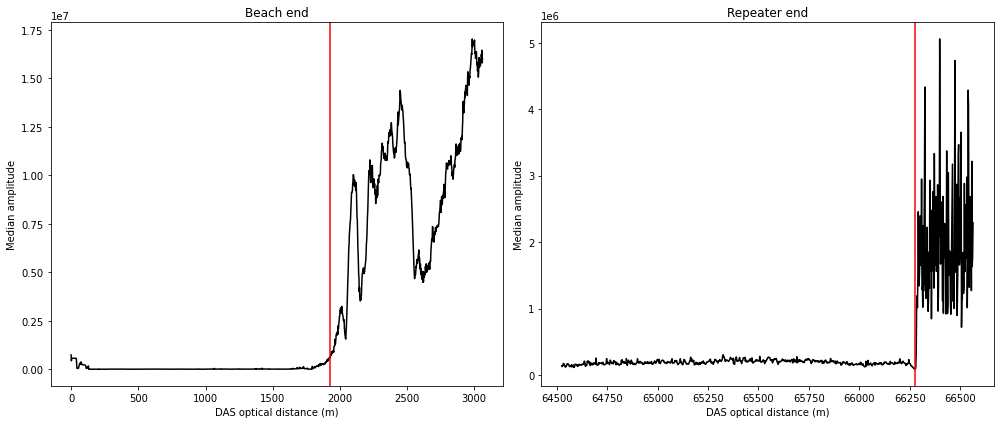

In [ ]:
# Plot the amplitude profile and pick the beach and repeater locations

x1_pick = 1923
x2_pick = 66278

fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(x1,amp1,'k')
ax[0].axvline(x1_pick,c='r')
ax[0].set_xlabel('DAS optical distance (m)')
ax[0].set_ylabel('Median amplitude')
ax[0].set_title('Beach end')
ax[1].plot(x2,amp2,'k')
ax[1].axvline(x2_pick,c='r')
ax[1].set_xlabel('DAS optical distance (m)')
ax[1].set_ylabel('Median amplitude')
ax[1].set_title('Repeater end')
plt.tight_layout()

Given these two reference points, we know how many channels fall between the beach and the repeater. Now, we can calculate the distance along the cable path and interpolate the right number of channels at a constant spacing. This simplistic analysis doesn't take into account the complexity of the tidal datum at the beach, spatial ambiguity from gauge length, or the effect of slope. The interpolation uncertainty should probably be considered about 1-2 gauge lengths (50-100 m). In this case, we have so few cable coordinate points that the cable location uncertainty is probably larger than the interpolation uncertainty. 

In [ ]:
# Set up DAS geometry
# for clarity, c now refers to channels and x refers to longitude
nc = nx                      # number of channels in 2-m data
dc = dx                      # channel spacing
c = np.arange(nc,dtype=int)
c0 = int(x1_pick//dc)
c1 = int(x2_pick//dc)        # channel numbers of beginning and end
c = c[c0:c1+1]               # cut off beginning and ending channels
nc = len(c)                  # new number of channels
d = np.arange(nc)*dc         # optical distance from first good channel

# Load cable coordinates and convert to northing/easting
tmp = np.genfromtxt('north_cable_latlon.txt')
lat = tmp[:,0]
lon = tmp[:,1]

myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
x,y = myProj(lon,lat)

# Calculate geographic distance along cable track 
xd = np.diff(x)
yd = np.diff(y)
dd = np.sqrt(xd**2 + yd**2)
u = np.cumsum(dd)
u = np.hstack(([0],u))

# Interpolate channel locations in x,y
du = np.linspace(0,u.max(),nc)
xc = np.interp(du,u,x)
yc = np.interp(du,u,y)

# Convert channel locations back to lat,lon
lonc,latc = myProj(xc,yc,inverse=True)

print('Optical channel spacing, ',dc)
print('Geographic channel spacing, ',du[1]-du[0])
print('Difference, ', (du[1]-du[0])/dc)

Optical channel spacing,  2.0419047
Geographic channel spacing,  2.0420484403940424
Difference,  1.0000704011864148


For having so few cable points to interpolate between, this is an astonishingly good result, with only a .007% difference between the interpolated geographic and a priori optical distances. 

Text(0, 0.5, 'Latitude')

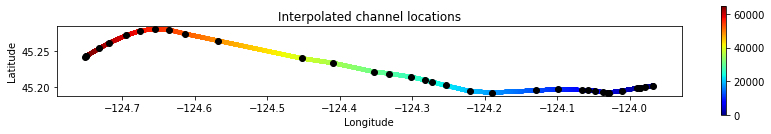

In [ ]:
## Plot
plt.figure(figsize=(14,2))
cb = plt.scatter(lonc,latc,c=du,marker='.',cmap='jet')
plt.scatter(lon,lat,c='k')
plt.colorbar(cb)
plt.gca().set_aspect('equal')
plt.title('Interpolated channel locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


You can download the geometry for the south cable and north cable here:

`!wget https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/north_cable_latlon.txt`

`!wget https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/south_cable_latlon.txt`

You can download the channel locations interpolated as above here:

`!wget https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/north_DAS_latlon.txt`

`!wget https://www.its.caltech.edu/~efwillia/OOI_RCA_DAS/south_DAS_latlon.txt`